# GWAS Prediction

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
import xgboost as xgb
import plotnine as p9
import scipy.stats
from plotnine import *
from torcheval.metrics import R2Score
import torch
from scipy.stats import wilcoxon, ttest_rel

## Data Preparation

### Load Covariates

In [2]:
def build_control_covariates(metadata):
    genesize = metadata.NPARAM.values.astype(float)
    genedensity = metadata.NPARAM.values/metadata.NSNPS.values
    inverse_mac = 1.0/metadata.MAC.values
    cov = np.stack((genesize, np.log(genesize), genedensity, np.log(genedensity), inverse_mac, np.log(inverse_mac)), axis=1)
    return cov

def munge_sigma(magma_gene_raw):
    f = open(magma_gene_raw)
    lines = list(f)[2:]
    lines = [np.asarray(line.strip('\n').split(' ')) for line in lines]
    sigmas = []
    gene_metadata = []
    gene_lists = []
    for chrom in range(1,23):
        chr_start = min(np.where([int(line[1])==chrom for line in lines])[0])
        chr_end = max(np.where([int(line[1])==chrom for line in lines])[0])
        lines_chr = lines[chr_start:chr_end+1]
        n_genes = len(lines_chr)
        sigma_chr = np.zeros([n_genes, n_genes])
        gene_NSNPs = np.zeros(n_genes)
        gene_NPARAM = np.zeros(n_genes)
        gene_MAC = np.zeros(n_genes)
        for i in range(n_genes):
            line = lines_chr[i]
            gene_NSNPs[i] = line[4]
            gene_NPARAM[i] = line[5]
            gene_MAC[i] = line[7]
            if line.shape[0] > 9:
                gene_corrs = np.asarray([float(c) for c in line[9:]])
                sigma_chr[i, i-gene_corrs.shape[0]:i] = gene_corrs
        sigma_chr = sigma_chr+sigma_chr.T+np.identity(n_genes)
        sigmas.append(sigma_chr)
        gene_metadata_chr = pd.DataFrame(data={'NSNPS': gene_NSNPs, 'NPARAM': gene_NPARAM, 'MAC': gene_MAC})
        gene_metadata.append(gene_metadata_chr)
        gene_list_chr = [line[0] for line in lines_chr]
        gene_lists.append(gene_list_chr)
    return sigmas, gene_metadata, gene_lists

In [3]:
def get_covariates(metadata, gene_lists):
    # create covariates from pops
    covariates = []
    for i in range(0, 22):
        #print(i)
        covariates.append(pd.DataFrame(build_control_covariates(metadata[i]),
                                       index = gene_lists[i],
                                       columns = ['genesize',
                                                  'log_genesize',
                                                  'genedensity',
                                                  'log_genedensity',
                                                  'inverse_mac',
                                                  'log_inverse_mac'])
                          )
    covariates = pd.concat(covariates)
    return covariates

### Load Embeddings

In [4]:
def get_embeddings(emb_name):
    emb_path = '../data/embeddings/'+emb_name+'.tsv'
    emb = pd.read_csv(emb_path, sep = "\t").set_index("gene_id")
    return emb

### Load GWAS MAGMA Scores

In [5]:
def load_magma(trait, covariates):
    magma = pd.read_csv('../data/input/GWAS/'+trait+'.genes.out', delim_whitespace=True)
    magma = magma.merge(covariates, left_on = "GENE", right_index = True)
    return magma

### Project Y to LY

In [6]:
def compute_Ls(sigmas, Y):
    Ls = []
    min_lambda=0
    for sigma in sigmas:
        W = np.linalg.eigvalsh(sigma)
        min_lambda = min(min_lambda, min(W))
    #Y = pd.read_table(args.gene_results+'.genes.out', delim_whitespace=True).ZSTAT.values
    ridge = abs(min_lambda)+.05+.9*max(0, np.var(Y)-1)
    for sigma in sigmas:
        sigma = sigma+ridge*np.identity(sigma.shape[0])
        L = np.linalg.cholesky(np.linalg.inv(sigma))
        Ls.append(L)
    return Ls

In [7]:
def project_Y(Ls, magma, gene_lists):
    LYs = []
    for i in range(22):
        L = Ls[i]
        magma_temp = magma.set_index("GENE").reindex(gene_lists[i]).reset_index()

        LYs.append(pd.DataFrame({"GENE": magma_temp.GENE, "LY": np.matmul(L, magma_temp.ZSTAT)}))
    return pd.concat(LYs)

def project_Y_back(Ls, res):
    LYs = []
    for i in range(22):
        L = np.linalg.inv(Ls[i])
        temp = res.set_index("GENE").reindex(gene_lists[i]).reset_index()

        LYs.append(pd.DataFrame({"GENE": temp.dropna().GENE,
                                 "pred_null": np.matmul(L[~temp.pred_LY_null.isna(), :][:, ~temp.pred_LY_null.isna()],
                                                   temp.dropna().pred_LY_null),
                                 "pred": np.matmul(L[~temp.pred_LY.isna(), :][:, ~temp.pred_LY.isna()],
                                                   temp.dropna().pred_LY),
                                 }))
    return pd.concat(LYs)

### Merge Data

In [8]:
def prepare_data(trait, emb_name):
  sigmas, metadata, gene_lists = munge_sigma('../data/input/GWAS/'+trait+'.genes.raw')
  covariates = get_covariates(metadata, gene_lists)
  
  emb = get_embeddings(emb_name)
  
  magma = load_magma(trait, covariates)
  
  # Add Ls
  Ls = compute_Ls(sigmas, magma.ZSTAT)
  magma = magma.merge(project_Y(Ls, magma, gene_lists))
  
  # Merge everything
  data = magma.merge(emb, left_on = "GENE", right_on = "gene_id")
  dict = {"sigmas": sigmas, "metadata": metadata, "gene_lists": gene_lists, "covariates": covariates, "embeddings": emb, "Ls": Ls}
  return data, dict

## Regression

Split by Chromosomes.

In [9]:
def regression_chrom_cv(dt, emb_cols, Ls, gene_lists):
    results = []
    
    for chrom in range(1,23):
        reg_null = xgb.XGBRegressor(tree_method="hist", reg_lambda = 1000, reg_alpha = 100)
        reg_full = xgb.XGBRegressor(tree_method="hist", reg_lambda = 1000, reg_alpha = 100)
        
        # Null model (covariates only)
        mod_null = reg_null.fit(
            dt.query("CHR != @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1).drop(emb_cols, axis=1),
            dt.query("CHR != @chrom")['LY']
        )
        pred_null = mod_null.predict(
            dt.query("CHR == @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1).drop(emb_cols, axis=1),
        )
        
        # Full model
        mod_full = reg_full.fit(
            dt.query("CHR != @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1),
            dt.query("CHR != @chrom")['LY']
        )
        pred_full = mod_full.predict(
            dt.query("CHR == @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1),
        )
    
        results_chrom = dt.query("CHR == @chrom")[["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"]]
        results_chrom['pred_LY_null'] = pred_null
        results_chrom['pred_LY'] = pred_full
    
        results.append(results_chrom)
        print(f"Chrom {chrom}: R2 (null): {scipy.stats.pearsonr(results_chrom.LY, results_chrom.pred_LY_null)[0]**2}")
        print(f"Chrom {chrom}: R2: {scipy.stats.pearsonr(results_chrom.LY, results_chrom.pred_LY)[0]**2}")
    
    print()
    
    results = pd.concat(results)
    results = results.merge(project_Y_back(Ls, results))
    
    print(f"Overall R2 (null): {scipy.stats.pearsonr(results.ZSTAT, results.pred_null)[0]**2}")
    print(f"Overall R2: {scipy.stats.pearsonr(results.ZSTAT, results.pred)[0]**2}")

    return results

In [10]:
def r2_per_chrom(reg_results):
    print("Per chrom R2 (full):")

    per_chrom_r2 = []
    for i in range(1, 23):
        res_tmp = reg_results.query("CHR == @i")
        r2 = scipy.stats.pearsonr(res_tmp.ZSTAT, res_tmp.pred)[0]**2
        per_chrom_r2.append(r2)
        print(r2)
    
    chromosomes = list(range(1, 23))
    df = pd.DataFrame({'Chromosome': chromosomes, 'R2': per_chrom_r2})
    
    # Plot R^2 values across chromosomes
    return (ggplot(df, aes(x='factor(Chromosome)', y='R2')) +
     geom_bar(stat='identity') +
     labs(title='R^2 Across Chromosomes', x='Chromosome', y='R2'))

## Plotting

In [11]:
# scatter plot (of predicted vs. true values)
def scatter(dataframe, x, y, x_label, y_label, color=None, alpha=0.1, smooth=True, facet=None):
    if color is not None:
        dataframe[color] = pd.Categorical(dataframe[color])
        p = ggplot(dataframe, aes(x, y, color=color)) + geom_point(alpha=alpha) + labs(x=x_label, y=y_label)
    else:
        p = ggplot(dataframe, aes(x, y)) + geom_point(alpha=alpha) + labs(x=x_label, y=y_label)
    if smooth:
        p += geom_smooth(method="lm")
    if facet:
        p += facet_wrap("~" + facet)
    p += geom_abline()
    return p

In [37]:
# plot r2 score
def compare_r2(dataframe=None, true = "ZSTAT", null = "pred_null", full="pred", r2_null=None, r2_full=None):
    if dataframe is not None:
        r2_null=[]
        r2_full=[]
        for i in range(1,23):
            df = dataframe.query("CHR == @i")
            r2_null.append(R2Score().update(torch.tensor(df[null].values), torch.tensor(df[true].values)).compute().numpy())
            r2_full.append(R2Score().update(torch.tensor(df[full].values), torch.tensor(df[true].values)).compute().numpy())
    r2 = pd.DataFrame({
        "r2_null": np.array(r2_null),
        "r2_full": np.array(r2_full),
        "r2_delta": (np.array(r2_full) - np.array(r2_null))})
    df1 = pd.melt(r2, value_vars=["r2_null", "r2_full"], var_name="model", value_name="r2")
    p1 = ggplot(df1, aes("model","r2")) + geom_boxplot()
    p2 = ggplot(r2, aes("r2_delta")) + geom_histogram()

    t_stat, t_p_value = ttest_rel(r2['r2_null'], r2['r2_full'])
    print(f't-test p-value for the difference in means: {t_p_value:.4f}')
    
    w_stat, w_p_value = wilcoxon(r2['r2_null'], r2['r2_full'])
    print(f'Wilcoxon p-value: {w_p_value:.4f}')
    
    # Add p-value to the plot
    if w_p_value is not None:
        p1 = p1 + labs(subtitle=f'Wilcoxon p = {w_p_value:.4f}, t-test p = {t_p_value:.4f}')
    
    return p1, p2

# Run

In [13]:
trait = 'HDL_cholesterol'
emb_name = 'GTEx_PCA_d64'
data, metadata = prepare_data(trait, emb_name)
data

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P,genesize,...,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64
0,ENSG00000187634,1,860260,879955,91,21,422405,1.89430,0.029092,21.0,...,0.059121,0.013806,-0.051162,-0.025453,-0.028243,-0.029078,0.002020,-0.008214,-0.012759,0.008408
1,ENSG00000188976,1,879584,894689,66,11,422405,3.07660,0.001047,11.0,...,-0.051868,0.059973,-0.085325,-0.121684,-0.066362,0.093838,0.003035,0.050440,0.113855,-0.090506
2,ENSG00000187961,1,895967,901095,37,7,422405,3.00680,0.001320,7.0,...,-0.006322,0.022571,0.045618,-0.075904,-0.019150,0.030177,-0.027622,0.053838,-0.003246,-0.030579
3,ENSG00000187583,1,901877,911245,49,19,422405,1.90960,0.028095,19.0,...,0.013522,-0.011667,-0.001540,0.002836,-0.003404,0.004544,-0.002154,-0.007398,-0.003116,0.000166
4,ENSG00000187642,1,910579,917497,28,7,422405,3.89010,0.000050,7.0,...,0.006345,-0.003005,-0.002617,0.003653,-0.006708,-0.005862,-0.003741,-0.007622,-0.001050,0.002811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17850,ENSG00000008735,22,51039114,51052409,66,14,422405,1.51710,0.064622,14.0,...,0.010218,-0.004502,0.000103,0.008257,-0.001828,0.006331,-0.000843,-0.012695,0.002413,0.008941
17851,ENSG00000100299,22,51061182,51066607,36,12,422405,2.77490,0.002761,12.0,...,0.054443,0.007890,0.074965,-0.071630,-0.068792,-0.043999,0.002654,-0.076466,0.047547,-0.023081
17852,ENSG00000251322,22,51112843,51171726,169,35,422405,0.62568,0.265760,35.0,...,-0.331636,0.139399,0.127251,-0.462468,-0.006313,0.044623,-0.044224,0.119150,-0.097047,-0.279560
17853,ENSG00000100312,22,51176624,51183762,36,10,422405,1.33790,0.090472,10.0,...,0.007732,0.001852,0.015429,-0.018261,0.010838,-0.008863,-0.023085,-0.000386,-0.001533,0.005484


In [14]:
emb_cols = metadata["embeddings"].columns.to_list()
Ls = metadata["Ls"]
gene_lists = metadata["gene_lists"]
reg_results = regression_chrom_cv(data, emb_cols, Ls, gene_lists)

Chrom 1: R2 (null): 0.05396559137157541
Chrom 1: R2: 0.07046944735556422
Chrom 2: R2 (null): 0.10078974317426145
Chrom 2: R2: 0.09762896891970924
Chrom 3: R2 (null): 0.060504405546230655
Chrom 3: R2: 0.08318341928245852
Chrom 4: R2 (null): 0.05496826019619744
Chrom 4: R2: 0.06073611832025127
Chrom 5: R2 (null): 0.08264528310967967
Chrom 5: R2: 0.0853022152260267
Chrom 6: R2 (null): 0.038551873217774264
Chrom 6: R2: 0.03517978930367818
Chrom 7: R2 (null): 0.040538408998674925
Chrom 7: R2: 0.057406310641979805
Chrom 8: R2 (null): 0.053858353415439354
Chrom 8: R2: 0.06463664551270255
Chrom 9: R2 (null): 0.06077630872194202
Chrom 9: R2: 0.08324039226991031
Chrom 10: R2 (null): 0.05735999296212273
Chrom 10: R2: 0.06952344190425641
Chrom 11: R2 (null): 0.03621223022066259
Chrom 11: R2: 0.04910285649922582
Chrom 12: R2 (null): 0.028202479597138622
Chrom 12: R2: 0.04446352648178265
Chrom 13: R2 (null): 0.08508911003916261
Chrom 13: R2: 0.06344519910337709
Chrom 14: R2 (null): 0.052828979121173

Per chrom R2 (full):
0.07948893460570777
0.06065681115452023
0.1955257717627445
0.07300279851910552
0.03675052983009157
0.24809915289953316
0.054853661831332154
0.05642339138999417
0.08786142226265252
0.05449199336946204
0.1013296562029893
0.08767578742499506
0.04702820343345462
0.07505478817395267
0.10200400712668357
0.13516020288073505
0.08252471561735927
0.04653588037736781
0.03963303158023101
0.17419851988477175
0.2723440853523539
0.09369455745782088


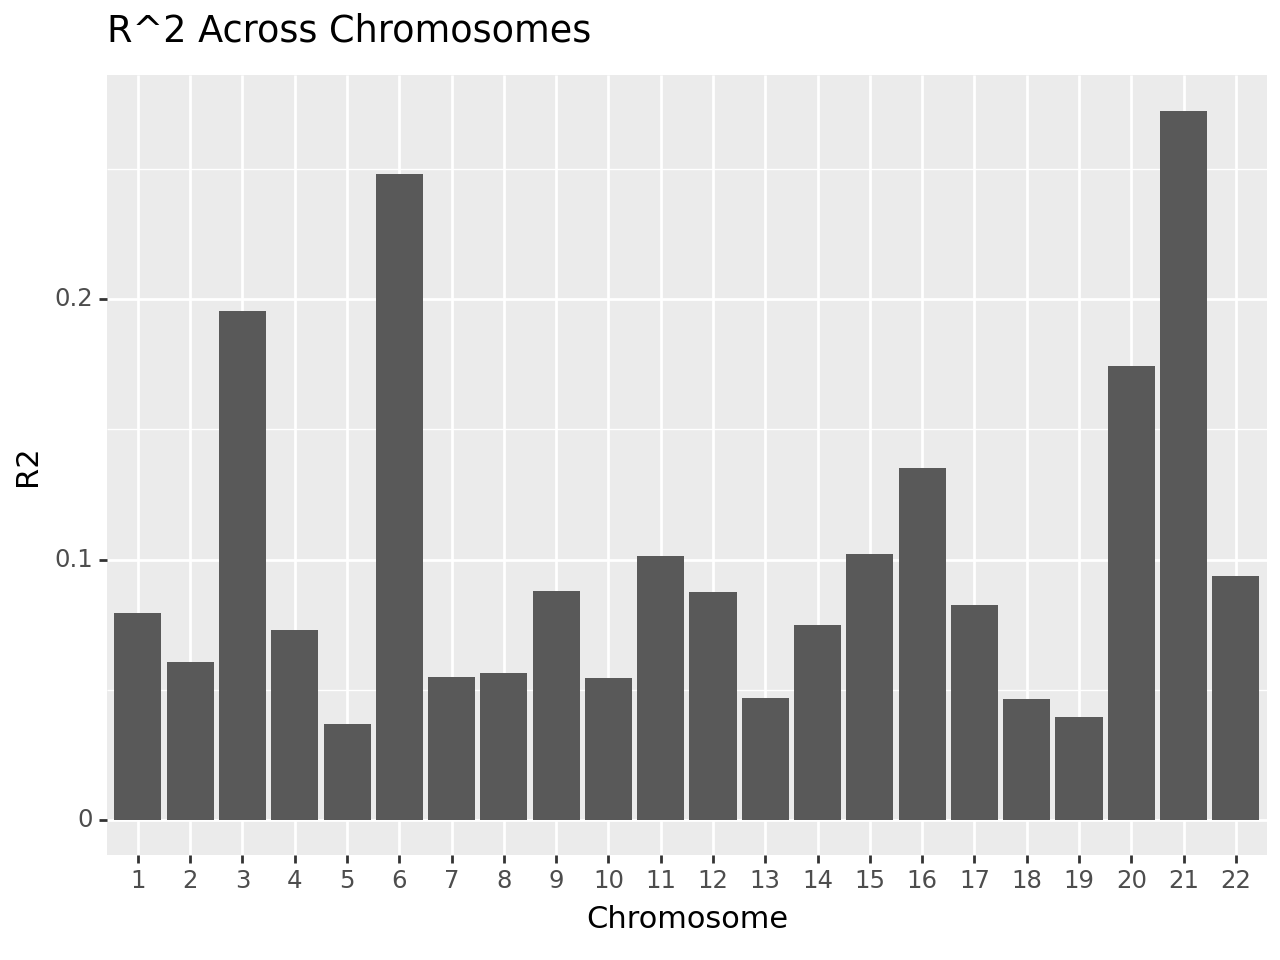

<Figure Size: (640 x 480)>

In [15]:
r2_per_chrom(reg_results)

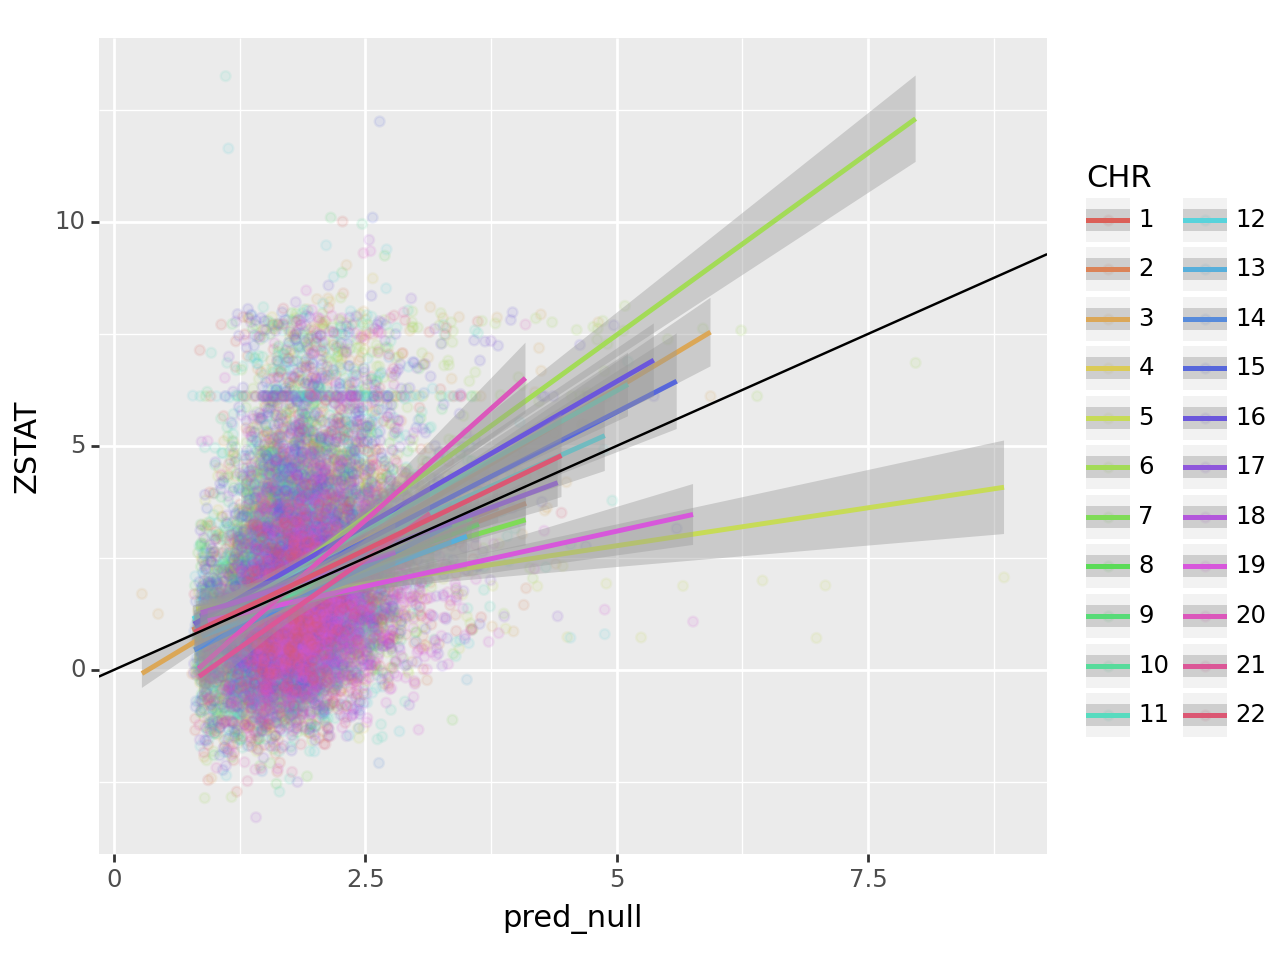

<Figure Size: (640 x 480)>

In [16]:
scatter(reg_results, "pred_null", "ZSTAT", "pred_null", "ZSTAT", color = "CHR", smooth=True)

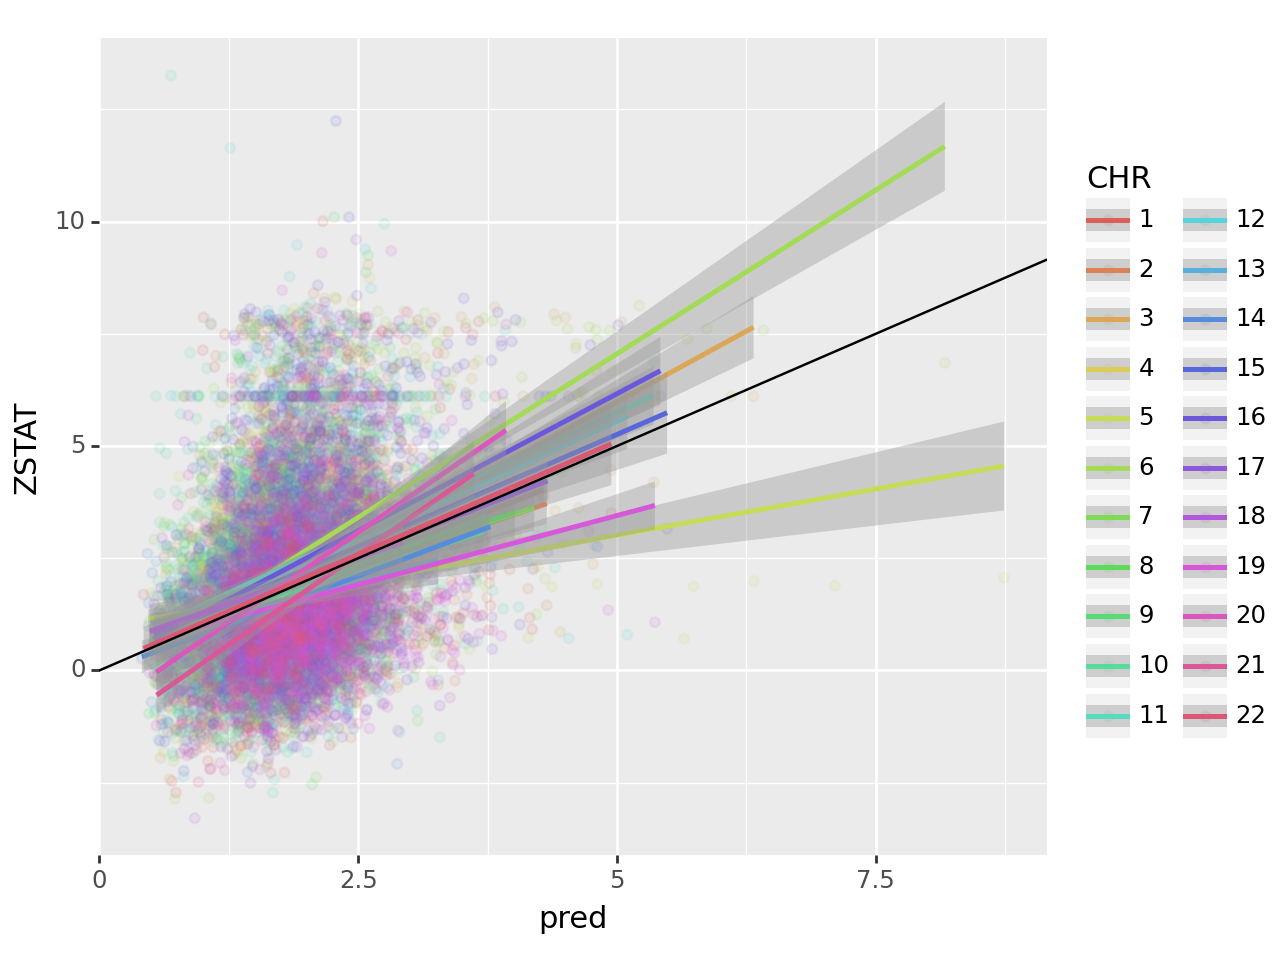

<Figure Size: (640 x 480)>

In [17]:
scatter(reg_results, "pred", "ZSTAT", "pred", "ZSTAT", color = "CHR", smooth=True)

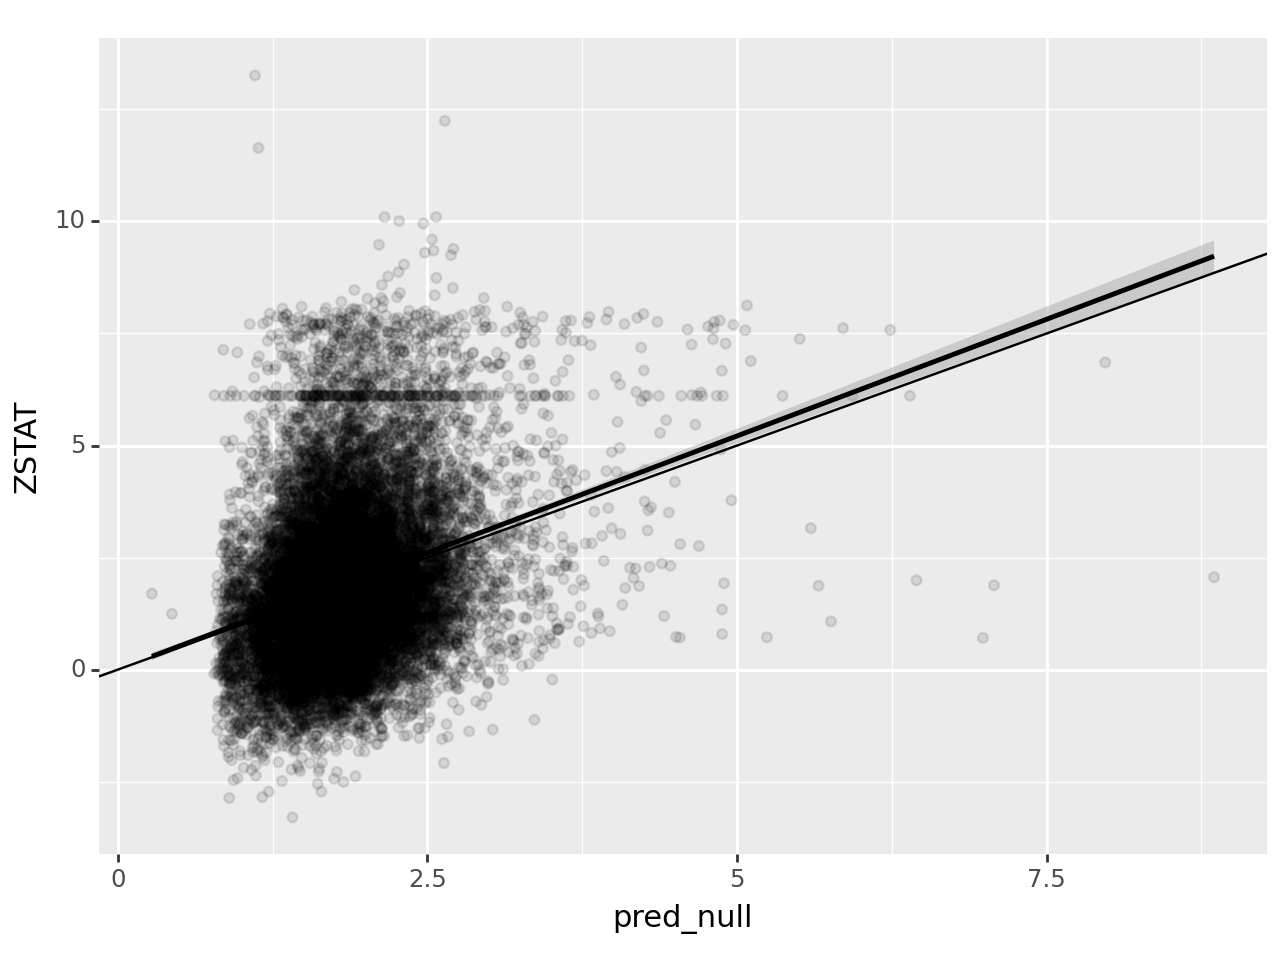

<Figure Size: (640 x 480)>

In [18]:
scatter(reg_results, "pred_null", "ZSTAT", "pred_null", "ZSTAT", color = None, smooth=True)

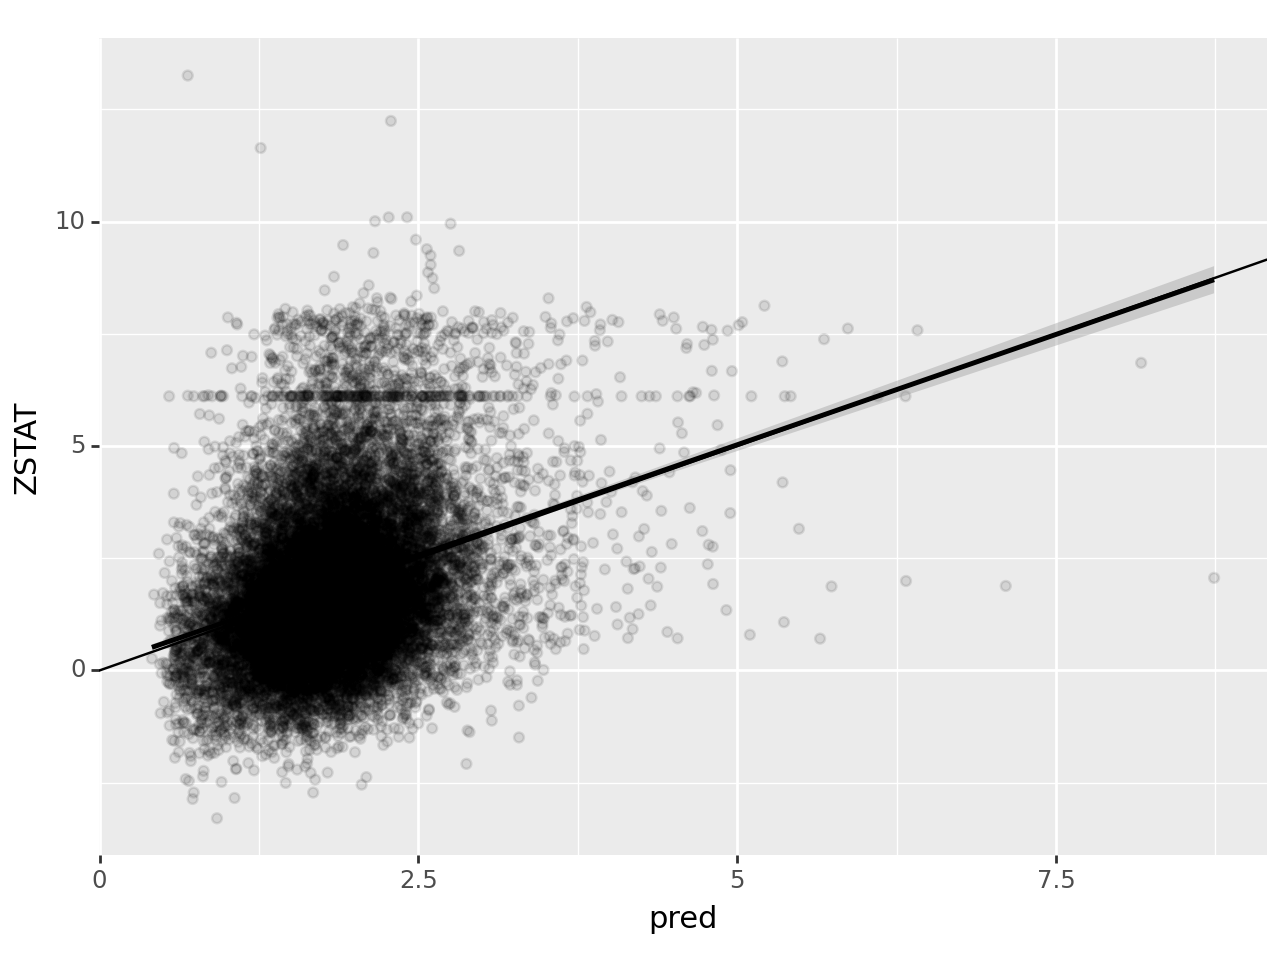

<Figure Size: (640 x 480)>

In [19]:
scatter(reg_results, "pred", "ZSTAT", "pred", "ZSTAT", color = None, smooth=True)

t-test p-value for the difference in means: 0.0112
Wilcoxon p-value: 0.0047


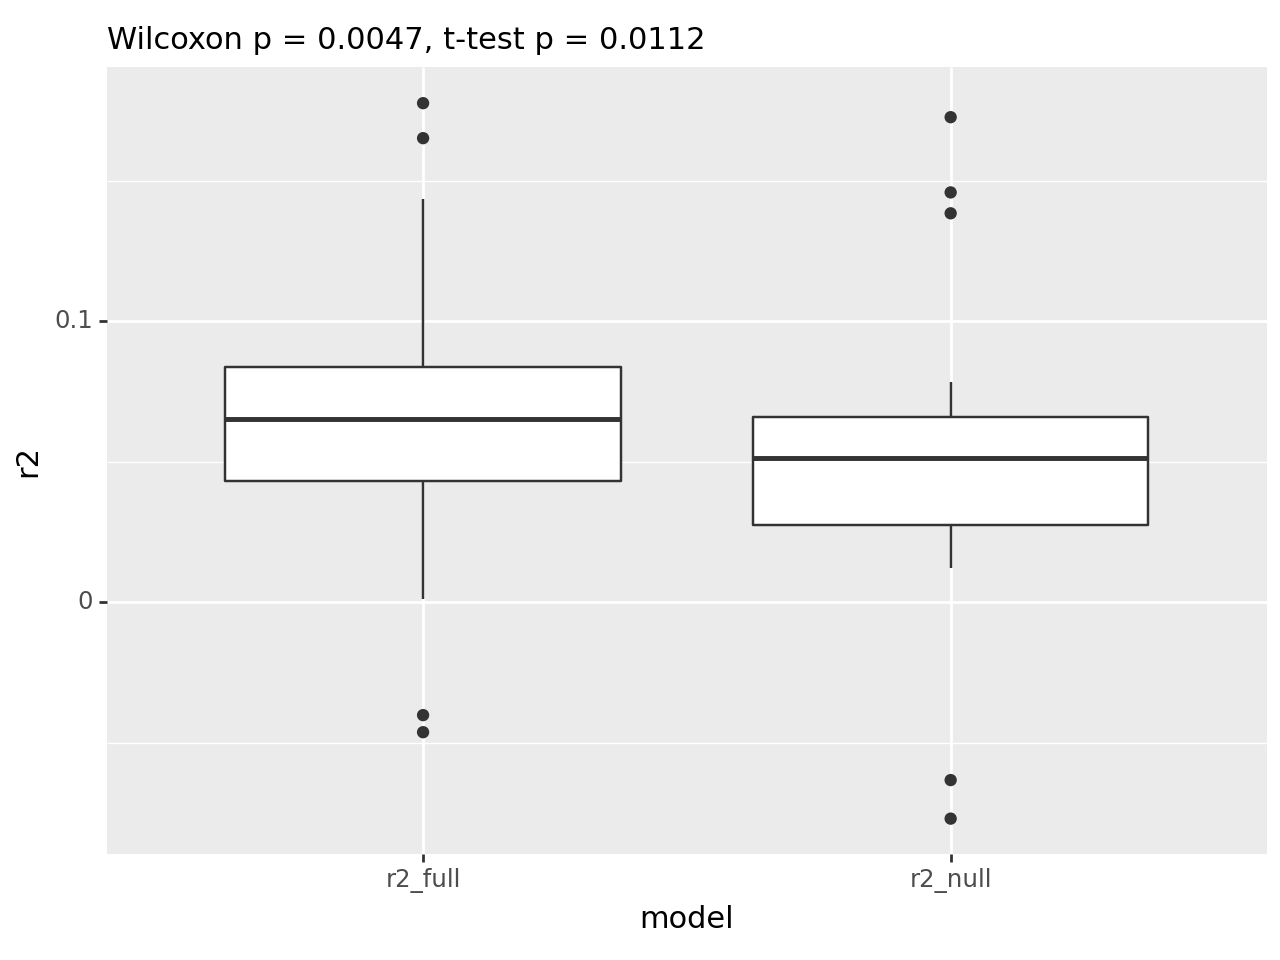

/home/niklas/Documents/TUM/5-WS2324/SysGen/Project/repo/notebooks/venv/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 10'. Pick better value with 'binwidth'.


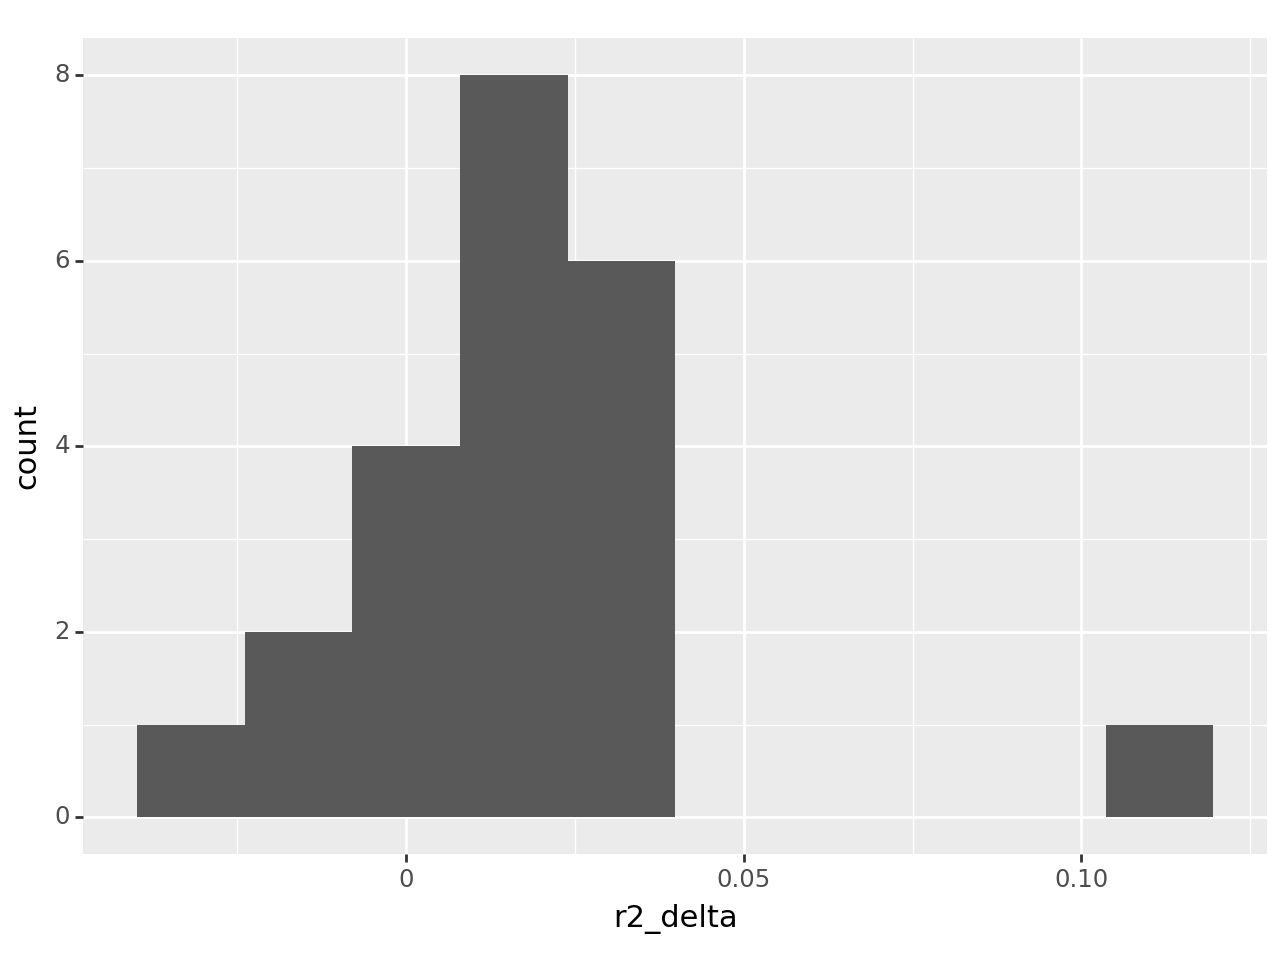

(<Figure Size: (640 x 480)>, <Figure Size: (640 x 480)>)

In [38]:
compare_r2(reg_results)